#### Data Parsing and Feature Extraction

In [33]:
import pandas as pd
import numpy as np
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [22]:
real_folder = '/Users/siddharthiyer/Documents/GitHub/dsl_final_project_ai_vs_real_art/detect ai artwork - resizing images for efficiency/ai vs real art/REAL'
fake_folder = '/Users/siddharthiyer/Documents/GitHub/dsl_final_project_ai_vs_real_art/detect ai artwork - resizing images for efficiency/ai vs real art/FAKE'

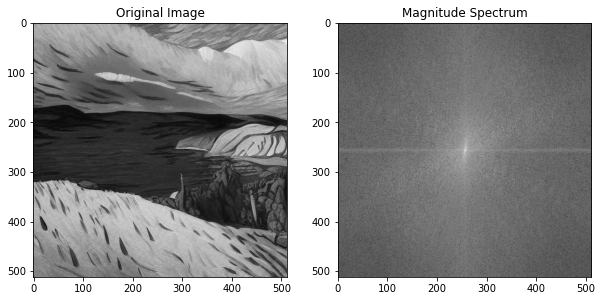

In [23]:
real_fft = []
fake_fft = []

output_real_folder = '/Users/siddharthiyer/Documents/GitHub/dsl_final_project_ai_vs_real_art/detect ai artwork - resizing images for efficiency/frequency_analysis/real_ffts'
output_fake_folder = '/Users/siddharthiyer/Documents/GitHub/dsl_final_project_ai_vs_real_art/detect ai artwork - resizing images for efficiency/frequency_analysis/fake_ffts'
os.makedirs(output_real_folder, exist_ok=True)
os.makedirs(output_fake_folder, exist_ok=True)

for filename in os.listdir(real_folder):
    image = Image.open(real_folder + '/' + filename).convert('L')
    image_np = np.array(image)
    f_transform = fft2(image_np)
    f_shifted = fftshift(f_transform)
    magnitude_spectrum = np.log(np.abs(f_shifted) + 1e-8)
    output_path = os.path.join(output_real_folder, filename.split('.')[0] + '_1.npy')
    np.save(output_path, magnitude_spectrum)

for filename in os.listdir(fake_folder):
    image = Image.open(fake_folder + '/' + filename).convert('L')
    image_np = np.array(image)
    f_transform = fft2(image_np)
    f_shifted = fftshift(f_transform)
    magnitude_spectrum = np.log(np.abs(f_shifted) + 1e-8)
    output_path = os.path.join(output_fake_folder, filename.split('.')[0] + '_0.npy')
    np.save(output_path, magnitude_spectrum)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image_np, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title('Magnitude Spectrum')
plt.show()

In [24]:
def get_mean_freq_2d(magnitude_spectrum):
    return np.mean(magnitude_spectrum)

def get_std_freq_2d(magnitude_spectrum):
    return np.std(magnitude_spectrum)

def get_skewness_freq_2d(magnitude_spectrum):
    return skew(magnitude_spectrum.flatten())

def get_kurtosis_freq_2d(magnitude_spectrum):
    return kurtosis(magnitude_spectrum.flatten())

def get_energy_freq_2d(magnitude_spectrum):
    return np.sum(magnitude_spectrum**2)

def get_entropy_freq_2d(magnitude_spectrum):
    normalized_spectrum = magnitude_spectrum / np.sum(magnitude_spectrum)
    return -np.sum(normalized_spectrum * np.log(normalized_spectrum + 1e-8))

def extract_features_and_create_dataframe(real_folder, fake_folder):
    data = []
    columns = ['Mean', 'Std', 'Skewness', 'Kurtosis', 'Energy', 'Entropy', 'Label']

    def process_folder(folder, label):
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            magnitude_spectrum = np.load(file_path)

            mean = get_mean_freq_2d(magnitude_spectrum)
            std = get_std_freq_2d(magnitude_spectrum)
            skewness = get_skewness_freq_2d(magnitude_spectrum)
            kurtosis = get_kurtosis_freq_2d(magnitude_spectrum)
            energy = get_energy_freq_2d(magnitude_spectrum)
            entropy = get_entropy_freq_2d(magnitude_spectrum)

            data.append([mean, std, skewness, kurtosis, energy, entropy, label])


    process_folder(real_folder, 1)  # Real images labeled as 1
    process_folder(fake_folder, 0)  # Fake images labeled as 0

    # Create DataFrame
    df = pd.DataFrame(data, columns=columns)
    return df

In [27]:
real_folder = '/Users/siddharthiyer/Documents/GitHub/dsl_final_project_ai_vs_real_art/detect ai artwork - resizing images for efficiency/frequency_analysis/real_ffts'
fake_folder = '/Users/siddharthiyer/Documents/GitHub/dsl_final_project_ai_vs_real_art/detect ai artwork - resizing images for efficiency/frequency_analysis/fake_ffts'

feature_df = extract_features_and_create_dataframe(real_folder, fake_folder)

feature_df.to_csv('image_fft_features.csv', index=False)
print(feature_df.head())

<ipython-input-24-7f43313c8b76>:18: RuntimeWarning: invalid value encountered in log
  return -np.sum(normalized_spectrum * np.log(normalized_spectrum + 1e-8))


       Mean       Std  Skewness  Kurtosis        Energy    Entropy  Label
0  8.571300  0.988061  0.159426  1.215908  1.951490e+07  12.467364      1
1  8.400005  1.030195  0.328297  1.291149  1.877511e+07  12.466533      1
2  7.597910  1.057859  0.219371  0.945817  1.542647e+07        NaN      1
3  8.069598  1.027617  0.347758  1.276599  1.734723e+07  12.465950      1
4  7.391994  1.037208  0.149188  0.883219  1.460597e+07  12.464127      1


#### Training Models on the Data

##### **XGBoost**

In [30]:
df = pd.read_csv('image_fft_features.csv')

X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, seed=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

##### Accuracy of Basic XGBoost Model then with Tuned Hyperparameters

In [32]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7859237536656891
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       328
           1       0.82      0.75      0.78       354

    accuracy                           0.79       682
   macro avg       0.79      0.79      0.79       682
weighted avg       0.79      0.79      0.79       682



In [40]:
# GridSearch Tuning

parameters = {
    'max_depth': [7, 8, 10],             # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1],  # Boosting learning rate
    'n_estimators': [300, 400],       # Number of gradient boosted trees
    'gamma': [0, 0.1, 0.2],          # Minimum loss reduction required to make further partition
    'reg_alpha': [0.1, 0.5, 1.0],                 # L1 regularization term on weights
    'reg_lambda': [0.5, 0.1, 0.01],               # L2 regularization term on weights
}

grid_search = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss'), parameters, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best score: 0.8046164323392047


In [41]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7961876832844574
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       328
           1       0.84      0.75      0.79       354

    accuracy                           0.80       682
   macro avg       0.80      0.80      0.80       682
weighted avg       0.80      0.80      0.80       682

